In [4]:
import pandas as pd
import numpy as np
from nsepy import get_history
import datetime
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import time
from dateutil.relativedelta import relativedelta
from datetime import date

In [ ]:
def index_to_date(bt_data):
    new_index = []
    for index in bt_data.index:
        temp = index.to_pydatetime().date()
        new_index.append(temp)
    bt_data.index = new_index
    return bt_data

In [6]:
def hist_data(factor):
    
    if factor == "Momentum" or factor == "momentum" or factor == "m":
        bt_data = pd.read_excel(r"Nifty200DailyReturns.xlsx", sheet_name = "Nifty 200 Return-16 Year")[1:]
        bt_data.set_index("Date", inplace = True)
        bt_data = index_to_date(bt_data)
        
    if factor == "Beta" or factor == "beta" or factor == "b":
        daily_p = pd.read_excel(r"Nifty200DailyReturns.xlsx", sheet_name = "BBG-Nifty 200 Prices-16 Year").iloc[:,1:]
        
        new_header = daily_p.iloc[0] 
        daily_p = daily_p[1:]
        daily_p.columns = new_header
        daily_p.set_index("Date", inplace = True)

        weekly_p = daily_p.resample('W').last()
        weekly_r = weekly_p.pct_change()[1:]
        bt_data = weekly_r
        bt_data = index_to_date(bt_data)
        
    if factor == "BetaNifty" or factor == "betanifty" or factor == "bn":
        daily_p = pd.read_excel(r"Nifty200DailyReturns.xlsx", sheet_name = "Nifty 50 Index Prices-16 Year").iloc[:,1:]
        
        new_header = daily_p.iloc[0] 
        daily_p = daily_p[1:]
        daily_p.columns = new_header
        daily_p.set_index("Date", inplace = True)

        weekly_p = daily_p.resample('W').last()
        weekly_r = weekly_p.pct_change()[1:]
        bt_data = weekly_r
        bt_data = index_to_date(bt_data)
        
    if factor == "nifty" or factor == "Nifty":
        bt_data = pd.read_excel(r"Nifty200DailyReturns.xlsx", sheet_name = "Nifty 50 Index Return-16 Year")[1:]
        bt_data.set_index("Date", inplace = True)
        bt_data = index_to_date(bt_data)
        
    if factor == "volatility" or factor == "Volatility" or factor == "vol":
        bt_data = pd.read_excel(r"Nifty200DailyReturns.xlsx", sheet_name = "Nifty 200 Return-16 Year")[1:]
        bt_data.set_index("Date", inplace = True)
        bt_data = index_to_date(bt_data)
    return bt_data

In [8]:
bt_data_momentum = hist_data("Momentum")
bt_data_volatility = hist_data("Volatility")
bt_data_beta = hist_data("Beta")
bt_data_beta_nifty = hist_data("BetaNifty")

In [9]:
def yearsago(years, from_date=None):
    if from_date is None:
        from_date = datetime.now()
    return from_date - relativedelta(years=years)

def monthsago(months, from_date=None):
    if from_date is None:
        from_date = datetime.now()
    return from_date - relativedelta(months=months+1)

def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [115]:
months_of_bt = 12*1
rebal_freq = '1m'
portfolio_size = 15
winsorize_pct = 0.02

In [306]:
bt_end = date(2021,3,1)
bt_start = date(2020,10,31)
rebal_dates= (pd.date_range(bt_start, bt_end , freq=rebal_freq)).to_list()

In [271]:
bt_end = date.today() - timedelta(1)
bt_start = monthsago(months_of_bt,bt_end)
rebal_dates= (pd.date_range(bt_start, bt_end , freq=rebal_freq)).to_list()

In [307]:
rebal_dates

[Timestamp('2020-10-31 00:00:00', freq='M'),
 Timestamp('2020-11-30 00:00:00', freq='M'),
 Timestamp('2020-12-31 00:00:00', freq='M'),
 Timestamp('2021-01-31 00:00:00', freq='M'),
 Timestamp('2021-02-28 00:00:00', freq='M')]

In [163]:
def outliers(final_df, factor):
    if factor == "Momentum" or factor == "momentum" or factor == "m":
        y = final_df['Momentum']
        outliers_downside = y.between(y.quantile(0), y.quantile(winsorize_pct))
        outliers_upside = y.between(y.quantile(1-winsorize_pct), y.quantile(1))
        low_cutoff_percentile_momentum = y.quantile(winsorize_pct)
        high_cutoff_percentile_momentum = y.quantile(1-winsorize_pct)
        outliers_downside_index = final_df[outliers_downside].index
        outliers_upside_index = final_df[outliers_upside].index
        for ind in outliers_downside_index:
            final_df.loc[ind, "Momentum"] = low_cutoff_percentile_momentum
        for ind in outliers_upside_index:
            final_df.loc[ind, "Momentum"] = high_cutoff_percentile_momentum
        
    if factor == "volatility" or factor == "Volatility" or factor == "vol":
        y = final_df["Volatility"]
        outliers_downside = y.between(y.quantile(0), y.quantile(winsorize_pct))
        outliers_upside = y.between(y.quantile(1-winsorize_pct), y.quantile(1))
        low_cutoff_percentile_volatility = y.quantile(winsorize_pct)
        high_cutoff_percentile_volatility = y.quantile(1-winsorize_pct)
        outliers_downside_index = final_df[outliers_downside].index
        outliers_upside_index = final_df[outliers_upside].index
        for ind in outliers_downside_index:
            final_df.loc[ind, "Volatility"] = low_cutoff_percentile_volatility
        for ind in outliers_upside_index:
            final_df.loc[ind, "Volatility"] = high_cutoff_percentile_volatility        

    if factor == "beta" or factor == "Beta":
        y = final_df["Beta"]
        outliers_downside = y.between(y.quantile(0), y.quantile(winsorize_pct))
        outliers_upside = y.between(y.quantile(1-winsorize_pct), y.quantile(1))
        low_cutoff_percentile_beta = y.quantile(winsorize_pct)
        high_cutoff_percentile_beta = y.quantile(1-winsorize_pct)
        outliers_downside_index = final_df[outliers_downside].index
        outliers_upside_index = final_df[outliers_upside].index
        for ind in outliers_downside_index:
            final_df.loc[ind, "Beta"] = low_cutoff_percentile_beta
        for ind in outliers_upside_index:
            final_df.loc[ind, "Beta"] = high_cutoff_percentile_beta                
            
    return final_df

In [164]:
def nifty(port_value):
    index = port_value.index
    first_date, last_date = index[0], index[-1]
    nifty_ret = bt_data_nifty
    if (index[1] - index[0]).days >= 6:
        nifty_ret = bt_data_beta_nifty
    for i in range(len(nifty_ret)):
        if nifty_ret.index[i] == first_date:
            start = i
        if nifty_ret.index[i] == last_date:
            end = i
    nifty_ret = nifty_ret.iloc[start:end+1]
    nifty_cum_ret = 100*np.cumprod(1 + nifty_ret)
    
    return nifty_cum_ret

In [165]:
def score(final_df):
    score = []
    for i in range(len(final_df)):
        if final_df.iloc[i]["Zscore"] >= 0:
            score.append(1 + final_df.iloc[i]["Zscore"])
        elif final_df.iloc[i]["Zscore"] < 0:
            score.append((1 - final_df.iloc[i]["Zscore"])**(-1))
        else:
            score.append(np.nan)
    return score

In [166]:
def get_bt_dates(factor, bt_data, rebal_date):
    if factor == "Momentum":
        rvrsl_prd = 1
        relevant_end_date = nearest(bt_data.index,(rebal_dates[rebal_date] - pd.DateOffset(months=rvrsl_prd)).to_pydatetime().date())
        relevant_start_date = nearest(bt_data.index, (rebal_dates[rebal_date] - pd.DateOffset(months=12)).to_pydatetime().date())
        relevant_returns = bt_data.loc[relevant_start_date:relevant_end_date]
        
    if factor == "Volatility":
        relevant_start_date = nearest(bt_data.index,(rebal_dates[rebal_date] - pd.DateOffset(years=2)).to_pydatetime().date())
        relevant_end_date = nearest(bt_data.index, (rebal_dates[rebal_date]).to_pydatetime().date())
        relevant_returns = bt_data.loc[(bt_data.index>relevant_start_date)&(bt_data.index<relevant_end_date)]
        
    if factor == "Beta":
        relevant_start_date = nearest(bt_data.index,(rebal_dates[rebal_date] - pd.DateOffset(years=1)).to_pydatetime().date())
        relevant_end_date = nearest(bt_data.index, (rebal_dates[rebal_date]).to_pydatetime().date())
        relevant_returns = bt_data.loc[(bt_data.index>relevant_start_date)&(bt_data.index<relevant_end_date)]
        
    return relevant_end_date, relevant_start_date, relevant_returns

In [167]:
def factor_calculation(factor, relevant_returns, bt_data):
    if factor == "Momentum":
        df_cum_returns = pd.DataFrame(columns = relevant_returns.columns)
        for ticker in relevant_returns.columns:
            df_cum_returns[ticker] = (1 + relevant_returns[ticker]).cumprod() - 1
        cumulative_returns = df_cum_returns[-1:].T
        all_sd = relevant_returns.std().dropna()
        all_sd = all_sd[~(all_sd == 0)].dropna()
        all_sd = all_sd.to_frame()
        all_sd = all_sd.reset_index().rename(columns = {"index" : "Company"})
        all_sd = all_sd.set_index("Company")
        all_sd["Ann SD"] = all_sd*np.sqrt(252)

        final_df = pd.merge(all_sd,cumulative_returns, left_index=True, right_index=True)
        columns = ["Daily SD", "Ann SD", "Cumulative Returns (12-1)"]
        final_df.columns = columns
        final_df["Momentum"] = final_df["Cumulative Returns (12-1)"]/final_df["Ann SD"]
    
    if factor == "Volatility":
        date_yr_ago = []
        for i in range(len(bt_data.index)):
            date_yr_ago.append(nearest(bt_data.index, bt_data.index[i] - relativedelta(days=365)))
        for i in range(len(relevant_returns)):
            if (relevant_returns.index[i] - date_yr_ago[i]).days > 363:
                relevant_index = i
                break
        calc_start_date = date_yr_ago[i]
        calc_end_date = relevant_returns.index[i-1]
        relevant_data_for_calc = relevant_returns.iloc[relevant_index:]
        cum_ret_df = pd.DataFrame(columns = relevant_data_for_calc.columns, index = relevant_data_for_calc.index)
        calc_start_dates = []
        calc_end_dates = []
        for i in range(len(relevant_data_for_calc)):
            calc_start_date = nearest(relevant_returns.index, (relevant_data_for_calc.index[i] - relativedelta(days = 365)))
            calc_end_date = relevant_data_for_calc.index[i]
            calc_start_dates.append(calc_start_date)
            calc_end_dates.append(calc_end_date)
        for i in range(len(cum_ret_df)):
            curr_date = cum_ret_df.index[i]
            cum_ret_df.loc[curr_date] = (((1 + relevant_returns[calc_start_dates[i]: calc_end_dates[i]]).cumprod() - 1)[-1:].values)
        final_df = pd.DataFrame(index = cum_ret_df.columns, columns = ["Max", "Min", "Volatility"])
        for i in cum_ret_df.columns:
            final_df.loc[i]["Max"] = cum_ret_df[i].max()
            final_df.loc[i]["Min"] = cum_ret_df[i].min()
            final_df.loc[i]["Volatility"] = final_df.loc[i]["Max"] - final_df.loc[i]["Min"]
        final_df["StdDev"] = np.std(bt_data.iloc[relevant_index:])
        
    if factor == "Beta":
        print("Change function call, special function for beta calculation")
    return final_df

In [168]:
def z_score(factor, final_df):
    final_df["Zscore"] = (final_df[factor] - final_df[factor].mean())/final_df[factor].std(ddof=0)
    return final_df

In [169]:
def rank_calculation(factor, score, final_df):
    if factor == "Momentum":
        final_df.rename(columns = {"Zscore": "Momentum ZScore"}, inplace = True)
        final_df["Momentum Score"] = score
        final_df["Momentum Rank"] = final_df["Momentum Score"].rank(ascending = False)
        final_df.sort_values(by = ["Momentum Rank","Cumulative Returns (12-1)"], ascending=[True,False],inplace = True)
        
    if factor == "Volatility":
        final_df.rename(columns = {"Zscore": "Volatility ZScore"}, inplace = True)
        final_df["Volatility Score"] = score
        final_df["Vol_Rank"] = final_df["Volatility Score"].rank(ascending=True)
        final_df["Std_Rank"] = final_df["StdDev"].rank(ascending=True)
        final_df['Average']= (final_df['Vol_Rank']+final_df['Std_Rank'])/2
        final_df.sort_values(by = "Average", inplace = True)
    
    if factor == "Beta":
        final_df.rename(columns = {"Zscore": "Beta ZScore"}, inplace = True)
        final_df["Beta Score"] = score
        final_df.dropna(how='any', inplace = True)
        final_df["Beta Rank"] = final_df["Beta Score"].rank(ascending = False)
        final_df.sort_values(by = ["Beta Rank"], ascending=[False],inplace = True) ##Set false for low beta
    
    return final_df

In [170]:
def portfolio_cum_returns_calc(final_daily_portfolio_returns):
    port_cum_ret = np.cumprod(1 + final_daily_portfolio_returns) - 1
    port_value = 100*(1+port_cum_ret)
    return port_value

In [171]:
def plot(port_value,nifty_value):
    plt.plot(port_value, label = "Portfolio")
    plt.plot(nifty_value, label = "Index")
    plt.legend()

In [139]:
def bt_calc(final_df, bt_data, rebal_date, final_daily_portfolio_returns):
    current_portfolio = final_df[:portfolio_size]
    current_portfolio = current_portfolio.index.to_list()
    weights = np.asarray([1/portfolio_size]*portfolio_size)     #Assume equal-weighted (can be changed)
    
    current_date = nearest(bt_data.index,rebal_dates[rebal_date].to_pydatetime().date())
    next_date = nearest(bt_data.index,rebal_dates[rebal_date+1].to_pydatetime().date())
    
    print(current_date, next_date)
    print(current_portfolio)
    
    portfolio_returns = bt_data[current_portfolio].loc[current_date:next_date]
    portfolio_cumulative_returns = pd.DataFrame(columns = portfolio_returns.columns)
    for ticker in portfolio_returns.columns:
        portfolio_cumulative_returns[ticker] = (1 + portfolio_returns[ticker]).cumprod() - 1
    portfolio_cumulative_returns = portfolio_cumulative_returns[-1:].T
    daily_portfolio_returns = weights@portfolio_returns.T
    
    df_daily_portfolio_returns = pd.DataFrame(daily_portfolio_returns)
    final_daily_portfolio_returns = final_daily_portfolio_returns.append(df_daily_portfolio_returns)
    final_daily_portfolio_returns = final_daily_portfolio_returns[~final_daily_portfolio_returns.index.duplicated(keep='last')]
    
    return final_daily_portfolio_returns

In [140]:
def nifty_beta_calculation(relevant_end_date,relevant_start_date, relevant_returns, bt_data_nifty):
    relevant_nifty_data = bt_data_nifty.loc[(bt_data_nifty.index>relevant_start_date)&(bt_data_nifty.index<relevant_end_date)]
    beta_df = pd.DataFrame(index = relevant_nifty_data.columns, columns = ["Beta"])
    beta_dict = {}
    for company in relevant_returns.columns:
        beta_dict[company] =  pd.merge(relevant_returns[company], relevant_nifty_data, left_index=True, right_index= True)
        beta_df.loc[company] = beta_dict[company].cov()[company]["NIFTY INDEX"]/beta_dict[company].cov()["NIFTY INDEX"]["NIFTY INDEX"]
    final_df = beta_df.reset_index().rename(columns={0:"Company"}).set_index("Company")
    final_df = final_df[1:]
    final_df["Beta"] = abs(final_df["Beta"])
    return final_df

In [141]:
def normalization_multi_factor(factor, final_df, dir):
    var = factor + " Score"
    if dir == "HTB":
        final_df[var] = (final_df[var]-final_df[var].min())/(final_df[var].max()-final_df[var].min())
    if dir == "LTB":
        final_df[var] = (final_df[var].max() - final_df[var])/(final_df[var].max()-final_df[var].min())
        
    return final_df

In [142]:
def merge_multi_factor(final_df1, final_df2, factor_1, factor_2):
    final_df = pd.concat([final_df1,final_df2],axis = 1)
    var_1 = factor_1 + " Score"
    var_2 = factor_2 + " Score"
    final_df["Final Score"] = (final_df[var_1] + final_df[var_2]) / 2
    final_df["Rank"] = final_df["Final Score"].rank(ascending = False)
    final_df.sort_values(by = "Rank", inplace = True)
    
    return final_df

In [143]:
def momentum():
    final_daily_portfolio_returns = pd.DataFrame()
    factor = "Momentum"
    bt_data = bt_data_momentum
    for rebal_date in range(len(rebal_dates)-1):
        print("**********{}***********".format(rebal_dates[rebal_date]))
        relevant_end_date,relevant_start_date, relevant_returns = get_bt_dates(factor, bt_data, rebal_date)        
        final_df = factor_calculation(factor,relevant_returns, bt_data)
        final_df = outliers(final_df, factor)
        final_df = z_score(factor, final_df)
        momentum_score = score(final_df)
        final_df = rank_calculation(factor, momentum_score, final_df)
        final_daily_portfolio_returns = bt_calc(final_df, bt_data, rebal_date, final_daily_portfolio_returns)
        
    port_value = portfolio_cum_returns_calc(final_daily_portfolio_returns)
    nifty_value = nifty(port_value)   
    plot(port_value, nifty_value)
    print("Portfolio Returns = {}; Index Returns = {}".format(port_value.iloc[-1], nifty_value.iloc[-1]))
    
    return port_value, nifty_value

def volatility():
    final_daily_portfolio_returns = pd.DataFrame()
    factor = "Volatility"
    bt_data = bt_data_volatility
    for rebal_date in range(len(rebal_dates)-1):
        print("**********{}***********".format(rebal_dates[rebal_date]))
        relevant_end_date,relevant_start_date, relevant_returns = get_bt_dates(factor, bt_data, rebal_date)  
        final_df = factor_calculation(factor,relevant_returns, bt_data)
        final_df = outliers(final_df, factor)
        final_df = z_score(factor, final_df)
        volatility_score = score(final_df)
        final_df = rank_calculation(factor, volatility_score, final_df)
        final_daily_portfolio_returns = bt_calc(final_df, bt_data, rebal_date, final_daily_portfolio_returns)
        
    port_value = portfolio_cum_returns_calc(final_daily_portfolio_returns)
    nifty_value = nifty(port_value)   
    plot(port_value, nifty_value)
    print("Portfolio Returns = {}; Index Returns = {}".format(port_value.iloc[-1], nifty_value.iloc[-1]))
    
    return port_value, nifty_value

def beta():
    final_daily_portfolio_returns = pd.DataFrame()
    factor = "Beta"
    bt_data = bt_data_beta
    bt_data_nifty = bt_data_beta_nifty
    for rebal_date in range(len(rebal_dates)-1):
        print("**********{}***********".format(rebal_dates[rebal_date]))
        relevant_end_date,relevant_start_date, relevant_returns = get_bt_dates(factor, bt_data, rebal_date)  
        final_df = nifty_beta_calculation(relevant_end_date,relevant_start_date, relevant_returns, bt_data_nifty)
        final_df = outliers(final_df, factor)
        final_df = z_score(factor, final_df)
        beta_score = score(final_df)
        final_df = rank_calculation(factor, beta_score, final_df)
        final_daily_portfolio_returns = bt_calc(final_df, bt_data, rebal_date, final_daily_portfolio_returns)
        
    port_value = portfolio_cum_returns_calc(final_daily_portfolio_returns)
    nifty_value = nifty(port_value)   
    plot(port_value, nifty_value)
    print("Portfolio Returns = {}; Index Returns = {}".format(port_value.iloc[-1], nifty_value.iloc[-1]))
    
    return port_value, nifty_value

def momentum_volatility():
    final_daily_portfolio_returns = pd.DataFrame()
    factor_1 = "Momentum"
    factor_2 = "Volatility"
    bt_data_1 = bt_data_momentum
    bt_data_2 = bt_data_volatility
    for rebal_date in range(len(rebal_dates)-1):
        print("**********{}***********".format(rebal_dates[rebal_date]))
        relevant_end_date,relevant_start_date, relevant_returns = get_bt_dates(factor_1, bt_data_1, rebal_date)        
        final_df = factor_calculation(factor_1,relevant_returns, bt_data_1)
        final_df = outliers(final_df, factor_1)
        final_df = z_score(factor_1, final_df)
        momentum_score = score(final_df)
        final_df_1 = rank_calculation(factor_1, momentum_score, final_df)
        final_df_1 = normalization_multi_factor(factor_1, final_df_1, "HTB")               #HTB=Higher the better
        
        relevant_end_date,relevant_start_date, relevant_returns = get_bt_dates(factor_2, bt_data_2, rebal_date)  
        final_df = factor_calculation(factor_2,relevant_returns, bt_data_2)
        final_df = outliers(final_df, factor_2)
        final_df = z_score(factor_2, final_df)
        volatility_score = score(final_df)
        final_df_2 = rank_calculation(factor_2, volatility_score, final_df)
        final_df_2 = normalization_multi_factor(factor_2, final_df_2, "LTB")
        
        final_df = merge_multi_factor(final_df_1,final_df_2, factor_1, factor_2)
        final_daily_portfolio_returns = bt_calc(final_df, bt_data_1, rebal_date, final_daily_portfolio_returns)
        
    port_value = portfolio_cum_returns_calc(final_daily_portfolio_returns)
    nifty_value = nifty(port_value)   
    plot(port_value, nifty_value)
    print("Portfolio Returns = {}; Index Returns = {}".format(port_value.iloc[-1], nifty_value.iloc[-1]))
    
    return port_value, nifty_value

def momentum_beta():
    final_daily_portfolio_returns = pd.DataFrame()
    factor_1 = "Momentum"
    factor_2 = "Beta"
    bt_data_1 = bt_data_momentum
    bt_data_2 = bt_data_beta
    bt_data_nifty = bt_data_beta_nifty
    for rebal_date in range(len(rebal_dates)-1):
        print("**********{}***********".format(rebal_dates[rebal_date]))
        relevant_end_date,relevant_start_date, relevant_returns = get_bt_dates(factor_1, bt_data_1, rebal_date)        
        final_df = factor_calculation(factor_1,relevant_returns, bt_data_1)
        final_df = outliers(final_df, factor_1)
        final_df = z_score(factor_1, final_df)
        momentum_score = score(final_df)
        final_df_1 = rank_calculation(factor_1, momentum_score, final_df)
        final_df_1 = normalization_multi_factor(factor_1, final_df_1, "HTB")               # HTB=Higher the better

        relevant_end_date,relevant_start_date, relevant_returns = get_bt_dates(factor_2, bt_data_2, rebal_date)  
        final_df = nifty_beta_calculation(relevant_end_date,relevant_start_date, relevant_returns, bt_data_nifty)
        final_df = outliers(final_df, factor_2)
        final_df = z_score(factor_2, final_df)
        beta_score = score(final_df)
        final_df_2 = rank_calculation(factor_2, beta_score, final_df)
        final_df_2 = normalization_multi_factor(factor_2, final_df_2, "LTB")
        
        final_df = merge_multi_factor(final_df_1,final_df_2, factor_1, factor_2)        
        final_daily_portfolio_returns = bt_calc(final_df, bt_data_1, rebal_date, final_daily_portfolio_returns)

    port_value = portfolio_cum_returns_calc(final_daily_portfolio_returns)
    nifty_value = nifty(port_value)   
    plot(port_value, nifty_value)
    print("Portfolio Returns = {}; Index Returns = {}".format(port_value.iloc[-1], nifty_value.iloc[-1]))
    
    return port_value, nifty_value

def volatility_beta():
    final_daily_portfolio_returns = pd.DataFrame()
    factor_1 = "Volatility"
    factor_2 = "Beta"
    bt_data_1 = bt_data_volatility
    bt_data_2 = bt_data_beta
    bt_data_nifty = bt_data_beta_nifty
    for rebal_date in range(len(rebal_dates)-1):
        print("**********{}***********".format(rebal_dates[rebal_date]))
        relevant_end_date,relevant_start_date, relevant_returns = get_bt_dates(factor_1, bt_data_1, rebal_date)  
        final_df = factor_calculation(factor_1,relevant_returns, bt_data_1)
        final_df = outliers(final_df, factor_1)
        final_df = z_score(factor_1, final_df)
        volatility_score = score(final_df)
        final_df_1 = rank_calculation(factor_1, volatility_score, final_df)
        final_df_1 = normalization_multi_factor(factor_1, final_df_1, "LTB")
        
        relevant_end_date,relevant_start_date, relevant_returns = get_bt_dates(factor_2, bt_data_2, rebal_date)  
        final_df = nifty_beta_calculation(relevant_end_date,relevant_start_date, relevant_returns, bt_data_nifty)
        final_df = outliers(final_df, factor_2)
        final_df = z_score(factor_2, final_df)
        beta_score = score(final_df)
        final_df_2 = rank_calculation(factor_2, beta_score, final_df)
        final_df_2 = normalization_multi_factor(factor_2, final_df_2, "LTB")
        
        final_df = merge_multi_factor(final_df_1,final_df_2, factor_1, factor_2)        
        final_daily_portfolio_returns = bt_calc(final_df, bt_data_1, rebal_date, final_daily_portfolio_returns)
        
    port_value = portfolio_cum_returns_calc(final_daily_portfolio_returns)
    nifty_value = nifty(port_value)   
    plot(port_value, nifty_value)
    print("Portfolio Returns = {}; Index Returns = {}".format(port_value.iloc[-1], nifty_value.iloc[-1]))
    
    return port_value, nifty_value

**********2020-10-31 00:00:00***********
2020-10-29 2020-12-01
['PG IN Equity', 'HUVR IN Equity', 'FORH IN Equity', 'MRCO IN Equity', 'ITC IN Equity', 'CLGT IN Equity', 'APNT IN Equity', 'DABUR IN Equity', 'TPW IN Equity', 'RJEX IN Equity', 'VGRD IN Equity', 'MRF IN Equity', 'SANL IN Equity', 'PWGR IN Equity', 'PAG IN Equity']
**********2020-11-30 00:00:00***********
2020-12-01 2020-12-31
['CLGT IN Equity', 'MRCO IN Equity', 'PG IN Equity', 'FORH IN Equity', 'HUVR IN Equity', 'APNT IN Equity', 'ITC IN Equity', 'VGRD IN Equity', 'DABUR IN Equity', 'TPW IN Equity', 'RJEX IN Equity', 'PFIZ IN Equity', 'PIDI IN Equity', 'MRF IN Equity', 'PWGR IN Equity']
**********2020-12-31 00:00:00***********
2020-12-31 2021-02-01
['PG IN Equity', 'CLGT IN Equity', 'FORH IN Equity', 'VGRD IN Equity', 'MRCO IN Equity', 'HUVR IN Equity', 'ITC IN Equity', 'DABUR IN Equity', 'APNT IN Equity', 'TPW IN Equity', 'RJEX IN Equity', 'PIDI IN Equity', 'MRF IN Equity', 'PWGR IN Equity', 'ACC IN Equity']
**********20

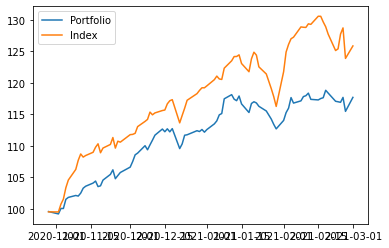

In [318]:
port_value, nifty_value = volatility_beta()

**********2020-10-31 00:00:00***********
2020-10-29 2020-12-01
['IPCA IN Equity', 'DRRD IN Equity', 'ADANIGR IN Equity', 'NFIL IN Equity', 'BIOS IN Equity', 'DIVI IN Equity', 'SYNG IN Equity', 'CRIN IN Equity', 'MTCL IN Equity', 'CIPLA IN Equity', 'TRP IN Equity', 'ESC IN Equity', 'CDH IN Equity', 'ALPM IN Equity', 'AJP IN Equity']
**********2020-11-30 00:00:00***********
2020-12-01 2020-12-31
['IPCA IN Equity', 'DRRD IN Equity', 'SYNG IN Equity', 'DIVI IN Equity', 'ADANIGR IN Equity', 'NFIL IN Equity', 'LTI IN Equity', 'MTCL IN Equity', 'AJP IN Equity', 'CIPLA IN Equity', 'CDH IN Equity', 'ALPM IN Equity', 'NTCPH IN Equity', 'CRIN IN Equity', 'ESC IN Equity']
**********2020-12-31 00:00:00***********
2020-12-31 2021-02-01
['IPCA IN Equity', 'DIVI IN Equity', 'ADANIGR IN Equity', 'SYNG IN Equity', 'NFIL IN Equity', 'ESC IN Equity', 'DRRD IN Equity', 'CDH IN Equity', 'LTI IN Equity', 'ATGL IN Equity', 'APHS IN Equity', 'CRIN IN Equity', 'AJP IN Equity', 'ALPM IN Equity', 'MTCL IN Equity'

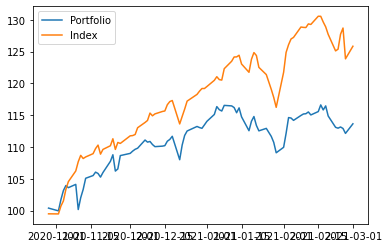

In [316]:
port_value, nifty_value = momentum_beta()

**********2020-10-31 00:00:00***********
2020-10-29 2020-12-01
['DRRD IN Equity', 'DIVI IN Equity', 'TRP IN Equity', 'IPCA IN Equity', 'SYNG IN Equity', 'SANL IN Equity', 'NTCPH IN Equity', 'APHS IN Equity', 'AJP IN Equity', 'ALKEM IN Equity', 'BIOS IN Equity', 'INFO IN Equity', 'LPC IN Equity', 'HCLT IN Equity', 'MPHL IN Equity']
**********2020-11-30 00:00:00***********
2020-12-01 2020-12-31
['DRRD IN Equity', 'DIVI IN Equity', 'SYNG IN Equity', 'AJP IN Equity', 'NTCPH IN Equity', 'MPHL IN Equity', 'DLPL IN Equity', 'HCLT IN Equity', 'INFO IN Equity', 'PI IN Equity', 'APNT IN Equity', 'APHS IN Equity', 'CIPLA IN Equity', 'MTCL IN Equity', 'LTI IN Equity']
**********2020-12-31 00:00:00***********
2020-12-31 2021-02-01
['DIVI IN Equity', 'DRRD IN Equity', 'APHS IN Equity', 'SYNG IN Equity', 'PI IN Equity', 'DLPL IN Equity', 'CDH IN Equity', 'NTCPH IN Equity', 'LTI IN Equity', 'INFOE IN Equity', 'INFO IN Equity', 'AJP IN Equity', 'IPCA IN Equity', 'ALKEM IN Equity', 'HCLT IN Equity']
***

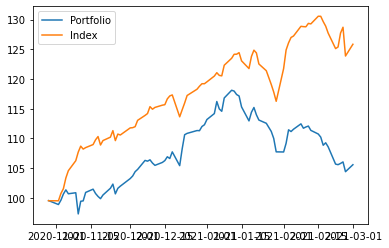

In [314]:
port_value, nifty_value = momentum_volatility()

**********2020-10-31 00:00:00***********
2020-11-01 2020-11-29
['LPC IN Equity', 'IPCA IN Equity', 'ITC IN Equity', 'PG IN Equity', 'BOOT IN Equity', 'HUVR IN Equity', 'TRP IN Equity', 'MRCO IN Equity', 'CLGT IN Equity', 'CRIN IN Equity', 'CDH IN Equity', 'FORH IN Equity', 'RJEX IN Equity', 'DRRD IN Equity', 'HZ IN Equity']
**********2020-11-30 00:00:00***********
2020-11-29 2021-01-03
['LPC IN Equity', 'BOOT IN Equity', 'PG IN Equity', 'IPCA IN Equity', 'CLGT IN Equity', 'HUVR IN Equity', 'ITC IN Equity', 'DRRD IN Equity', 'MRCO IN Equity', 'TRP IN Equity', 'AJP IN Equity', 'RJEX IN Equity', 'CDH IN Equity', 'CRIN IN Equity', 'FORH IN Equity']
**********2020-12-31 00:00:00***********
2021-01-03 2021-01-31
['LPC IN Equity', 'BOOT IN Equity', 'PG IN Equity', 'IPCA IN Equity', 'CLGT IN Equity', 'HUVR IN Equity', 'DRRD IN Equity', 'TRP IN Equity', 'ITC IN Equity', 'MRCO IN Equity', 'CDH IN Equity', 'CRIN IN Equity', 'AJP IN Equity', 'RJEX IN Equity', 'FORH IN Equity']
**********2021-01-31

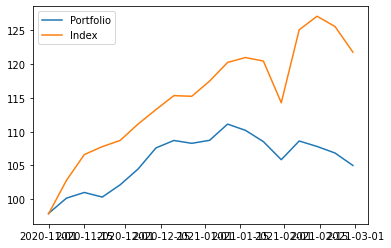

In [312]:
port_value, nifty_value = beta()

**********2020-10-31 00:00:00***********
2020-10-29 2020-12-01
['APNT IN Equity', 'PG IN Equity', 'HUVR IN Equity', 'DABUR IN Equity', 'CLGT IN Equity', 'NTPC IN Equity', 'MRCO IN Equity', 'ITC IN Equity', 'BOS IN Equity', 'CSTRL IN Equity', 'COAL IN Equity', 'PIDI IN Equity', 'SANL IN Equity', 'BJAUT IN Equity', 'OINL IN Equity']
**********2020-11-30 00:00:00***********
2020-12-01 2020-12-31
['APNT IN Equity', 'CLGT IN Equity', 'PG IN Equity', 'DABUR IN Equity', 'MRCO IN Equity', 'HUVR IN Equity', 'ITC IN Equity', 'HDFCB IN Equity', 'CSTRL IN Equity', 'BOS IN Equity', 'PIDI IN Equity', 'OINL IN Equity', 'BJAUT IN Equity', 'GCPL IN Equity', 'VGRD IN Equity']
**********2020-12-31 00:00:00***********
2020-12-31 2021-02-01
['PG IN Equity', 'CLGT IN Equity', 'DABUR IN Equity', 'APNT IN Equity', 'HUVR IN Equity', 'HDFCB IN Equity', 'MRCO IN Equity', 'ITC IN Equity', 'BOS IN Equity', 'PIDI IN Equity', 'NTPC IN Equity', 'CSTRL IN Equity', 'BJAUT IN Equity', 'GCPL IN Equity', 'VGRD IN Equity']

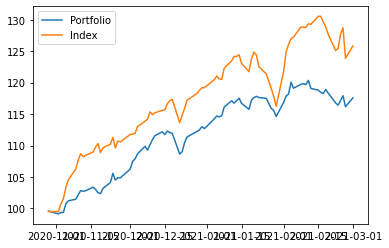

In [310]:
port_value, nifty_value = volatility()

**********2020-10-31 00:00:00***********
2020-10-29 2020-12-01
['ADANIGR IN Equity', 'DHANI IN Equity', 'NFIL IN Equity', 'IPCA IN Equity', 'DRRD IN Equity', 'DIVI IN Equity', 'BIOS IN Equity', 'MTCL IN Equity', 'SYNG IN Equity', 'CRIN IN Equity', 'CIPLA IN Equity', 'ESC IN Equity', 'TATACONS IN Equity', 'TRP IN Equity', 'BIL IN Equity']
**********2020-11-30 00:00:00***********
2020-12-01 2020-12-31
['ADANIGR IN Equity', 'NFIL IN Equity', 'IPCA IN Equity', 'DIVI IN Equity', 'SYNG IN Equity', 'DRRD IN Equity', 'MTCL IN Equity', 'LTI IN Equity', 'CIPLA IN Equity', 'AJP IN Equity', 'ALPM IN Equity', 'ESC IN Equity', 'CDH IN Equity', 'MUTH IN Equity', 'NTCPH IN Equity']
**********2020-12-31 00:00:00***********
2020-12-31 2021-02-01
['ADANIGR IN Equity', 'NFIL IN Equity', 'IPCA IN Equity', 'DIVI IN Equity', 'ATGL IN Equity', 'ESC IN Equity', 'SYNG IN Equity', 'LTI IN Equity', 'DRRD IN Equity', 'CDH IN Equity', 'ADE IN Equity', 'MTCL IN Equity', 'APHS IN Equity', 'ARBP IN Equity', 'PI IN Equ

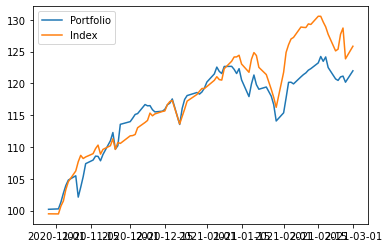

In [308]:
port_value, nifty_value = momentum()

PORT MDD = 2021-03-01   -0.046023
Name: MDD, dtype: float64; NIFTY MDD = 2021-03-01   -0.068974
Name: MDD, dtype: float64


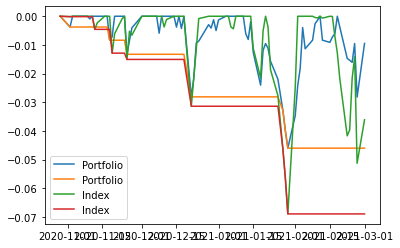

In [320]:
port_value = pd.DataFrame(port_value)
nifty_value = pd.DataFrame(nifty_value)
drawdown =  1 - port_value.div(port_value.cummax())
nifty_drawdown = 1 - nifty_value.div(nifty_value.cummax())

port_dd =  pd.concat([drawdown, drawdown.expanding().max()], axis=1)
port_dd.columns = ['drawdown', 'MDD']
nifty_df_dd =  pd.concat([nifty_drawdown, nifty_drawdown.expanding().max()], axis=1)
nifty_df_dd.columns = ['drawdown', 'MDD']

port_dd = port_dd*(-1)
nifty_df_dd = nifty_df_dd*(-1)

plt.plot(port_dd, label = "Portfolio")
plt.plot(nifty_df_dd, label = "Index")
plt.legend()

print("PORT MDD = {}; NIFTY MDD = {}".format(port_dd["MDD"][-1:], nifty_df_dd["MDD"][-1:]))

In [59]:
perf_data_frame = pd.merge(port_value, nifty_value, left_index=True, right_index=True)
perf_data_frame

,0,Nifty
2018-01-31,98.762359,99.801351
2018-02-01,98.652592,99.703611
2018-02-02,94.433862,97.384080
2018-02-05,94.444053,96.532922
2018-02-06,92.970405,95.009797
...,...,...
2018-12-24,103.710972,96.505319
2018-12-26,103.879683,97.105791
2018-12-27,104.524442,97.557841
2018-12-28,105.424606,98.282751


In [ ]:
perf_data_frame.to_excel("Momentum_1yr.xlsx")